# CNN-LSTM Portfolio Trading Strategy

In this notebook, we will backtest a trading strategy using CNN-LSTM models for portfolio construction. The plan:

1. Collect a decent number of relatively uncorrelated stocks. Since each model will take a bit of time to construct, we won't use too many stocks in this preliminary test. Maybe 20 stocks with low correlations ought to do it. 

2. Decide which factors would sensibly have predictive power of those stocks' returns. 

3. Create a separate CNN-LSTM model for each stock.

4. Using the CNN-LSTM prediction as the expected return and the covariance matrix over the last month, including the prediction, calculate the max sharpe portfolio over the next time period.

5. Train the models on new information and then rebalance.

Let's come up with a list of potential stocks. I'm just looking at a list of all stocks on the NYSE and picking some. They will be familiar companies, hopefully spread across industries. We will check these for correlation and if any of them are too high, we'll just replace those ones. Not a big deal. If it seems like they all begin with A, that's because the list I'm looking at is in alphabetical order. Shouldn't matter. We'll see.

1. Apple (AAPL), Tech
2. American Airlines (AAL), Travel
3. Advance Auto Parts (AAP), Auto
4. Albertson's (ACI), Groceries
5. American Eagle Outfitters (AEO), Fashion
6. Adobe Systems Incorporated (ADBE), Tech
7. American Financial Group (AFG), Finance
8. AFLAC (AFL), Insurance
9. AIG (AIG), Insurance
10. Ally Financial (ALLY), Finance
11. Applied Materials (AMAT), Manufacturing
12. AMC (AMC), Entertainment
13. AutoNation (AN), Auto
14. Atmos Energy (ATO), Energy
15. Altice Mobile (ATUS), Telecom
16. Activision Blizzard (ATVI), Gaming
17. American Express (AXP), Consumer Finance
18. Astrazeneca (AZN), Pharmaceutical
19. Booz Allen Hamilton (BAH), I am not sure
20. Best Buy (BBY), Retail

There's our starting 20. We will pull in past data for those stocks, then check them for correlation. If there are correlation problems, we will replace what needs replacing. Like I said before, not a problem. We will try using weekly data.

### Get Data

In [1]:
import pandas as pd
stock_symbols = ['AAPL', 'AAL', 'AAP', 'ACI', 'AEO', 'ADBE', 'AFG', 'AFL', 'AIG', 'ALLY',
                 'AMAT', 'AMC', 'AN', 'ATO', 'ATUS', 'ATVI', 'AXP', 'AZN', 'BAH', 'BBY']
data = pd.DataFrame(columns=['Date', 'Symbol', 'Adj Close', 'Volume'])
for symbol in stock_symbols:
    temp = pd.read_csv('https://query1.finance.yahoo.com/v7/finance/download/'+symbol+'?period1=1274054400&period2=1621209600&interval=1wk&events=history&includeAdjustedClose=true')
    temp['Symbol'] = symbol
    data = data.append(temp[['Date', 'Symbol', 'Adj Close', 'Volume']], ignore_index=True)

In [2]:
data.groupby('Symbol')['Date'].count()

Symbol
AAL     574
AAP     574
AAPL    574
ACI      47
ADBE    574
AEO     574
AFG     574
AFL     574
AIG     574
ALLY    381
AMAT    574
AMC     387
AN      574
ATO     574
ATUS    204
ATVI    574
AXP     574
AZN     574
BAH     548
BBY     574
Name: Date, dtype: int64

Okay. A few of these companies don't have 10 years of data available. We are going to replace those companies with similar companies. 

* Albertsons (ACI) - Replace with Kroger (KR). Chosen because they are both focused on groceries.
* Ally Financial (ALLY) - Replace with JP Morgan Chase (JPM).
* AMC - Replace with Cinemark (CNK). 
* Altice Mobile (ATUS) - Replace with Verizon (VZ)
* Booz Allen Hamilton (BAH) - Replace with...Accenture (ACN)

All of the new ones have at least 10 years of stock price data on Yahoo finance.

In [3]:
stock_symbols = ['AAPL', 'AAL', 'AAP', 'KR', 'AEO', 'ADBE', 'AFG', 'AFL', 'AIG', 'JPM',
                 'AMAT', 'CNK', 'AN', 'ATO', 'VZ', 'ATVI', 'AXP', 'AZN', 'ACN', 'BBY']

In [4]:
old_symbols = ['ACI', 'ALLY', 'AMC', 'ATUS', 'BAH']
new_symbols = ['KR', 'JPM', 'CNK', 'VZ', 'ACN']

for i in range(len(old_symbols)):
    data = data.drop(data[data['Symbol'] == old_symbols[i]].index)
    temp = pd.read_csv('https://query1.finance.yahoo.com/v7/finance/download/'+new_symbols[i]+'?period1=1274054400&period2=1621209600&interval=1wk&events=history&includeAdjustedClose=true')
    temp['Symbol'] = new_symbols[i]
    data = data.append(temp[['Date', 'Symbol', 'Adj Close', 'Volume']], ignore_index=True)

In [5]:
data.groupby('Symbol')['Date'].count()

Symbol
AAL     574
AAP     574
AAPL    574
ACN     574
ADBE    574
AEO     574
AFG     574
AFL     574
AIG     574
AMAT    574
AN      574
ATO     574
ATVI    574
AXP     574
AZN     574
BBY     574
CNK     574
JPM     574
KR      574
VZ      574
Name: Date, dtype: int64

Good! Now let's check for missing values. I don't expect any.

In [6]:
data.isna().sum()

Date         0
Symbol       0
Adj Close    0
Volume       0
dtype: int64

Perfect. The stock price data is ready. Time to check for correlation.

### Check for correlation

In [7]:
# change Date to index
data = data.set_index('Date')

# melt it to wide form
data_wide = data.pivot(columns = 'Symbol')
data_wide

Adj Close                                                  \
Symbol            AAL         AAP        AAPL         ACN        ADBE   
Date                                                                    
2010-05-17   6.797166   47.662289    7.430714   30.655373   32.180000   
2010-05-24   8.324407   49.868587    7.877193   30.157042   32.080002   
2010-05-31   8.098148   48.327076    7.848980   29.682831   31.590000   
2010-06-07   9.361423   48.664284    7.773851   30.253494   31.730000   
2010-06-14   9.842220   49.704815    8.404319   31.290335   33.520000   
...               ...         ...         ...         ...         ...   
2021-04-12  22.030001  191.940308  133.732147  285.269379  525.080017   
2021-04-19  21.110001  198.735626  133.891632  290.918793  515.840027   
2021-04-26  21.719999  199.143555  131.040756  289.153778  508.339996   
2021-05-03  22.000000  203.431656  129.794739  290.709381  488.730011   
2021-05-10  22.400000  201.780090  127.259331  287.388763  486.559998   

                                                                     ...  \
Symbol            AEO         AFG        AFL        AIG        AMAT  ...   
Date                                                                 ...   
2010-05-17   9.914284   16.383945  16.326286  24.863037   10.235832  ...   
2010-05-24   8.601133   16.911280  16.770996  24.462027   10.396771  ...   
2010-05-31   7.970821   16.468805  15.646624  24.026442   10.171099  ...   
2010-06-07   8.706185   16.971899  16.199348  24.254597   10.268200  ...   
2010-06-14   8.542042   17.359829  16.808849  26.211296   10.794147  ...   
...               ...         ...        ...        ...         ...  ...   
2021-04-12  34.303932  104.947922  52.832516  46.535061  133.252808  ...   
2021-04-19  37.676620  109.240868  52.753437  46.772186  134.378784  ...   
2021-04-26  34.393471  108.428940  53.109280  47.868874  132.236465  ...   
2021-05-03  36.612083  113.582970  55.461784  50.576004  132.475616  ...   
2021-05-10  36.373310  114.880310  55.807743  51.277489  124.384583  ...   

              Volume                                                   \
Symbol            AN      ATO      ATVI       AXP       AZN       BBY   
Date                                                                    
2010-05-17  18678400  2779900  67731700  87846600  32726600  29262300   
2010-05-24  19251600  2291100  73329600  65799200  27493600  35164200   
2010-05-31  13386500  1247300  42808500  51288200  19956800  36147000   
2010-06-07  11660800  2334200  46834100  54696900  24794800  34700700   
2010-06-14  12487100  1328900  66708800  47452700  15416200  62997100   
...              ...      ...       ...       ...       ...       ...   
2021-04-12   2500800  3314700  28947900  12524100  63557200   9668500   
2021-04-19   4833200  3758200  27068900  16590100  57493500  10125400   
2021-04-26   4583000  3946300  32081600  15446400  49387700   7729600   
2021-05-03   5175000  3467700  49404800  14169500  32425200   8165200   
2021-05-10   3611800  3795300  27172000  14537500  36697700  11580200   

                                                       
Symbol           CNK        JPM         KR         VZ  
Date                                                   
2010-05-17   6460200  348994600  101683800  139343462  
2010-05-24   3156900  252770300  161416200  113639673  
2010-05-31   5550500  161286400   60666200   73799351  
2010-06-07   3847500  213582400   88043000   94625376  
2010-06-14   3343900  203260800  115387400   99264306  
...              ...        ...        ...        ...  
2021-04-12  10653100   79794100   38146600   82148400  
2021-04-19  14996700   67151600   32077200   85960400  
2021-04-26  11481600   57246000   35333900   84825400  
2021-05-03  14560300   63085700   43281200   87780700  
2021-05-10  15149100   69826700   47627700   82328600  

[574 rows x 40 columns]

In [8]:
close_prices = data_wide['Adj Close']
cormat = close_prices.corr()

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

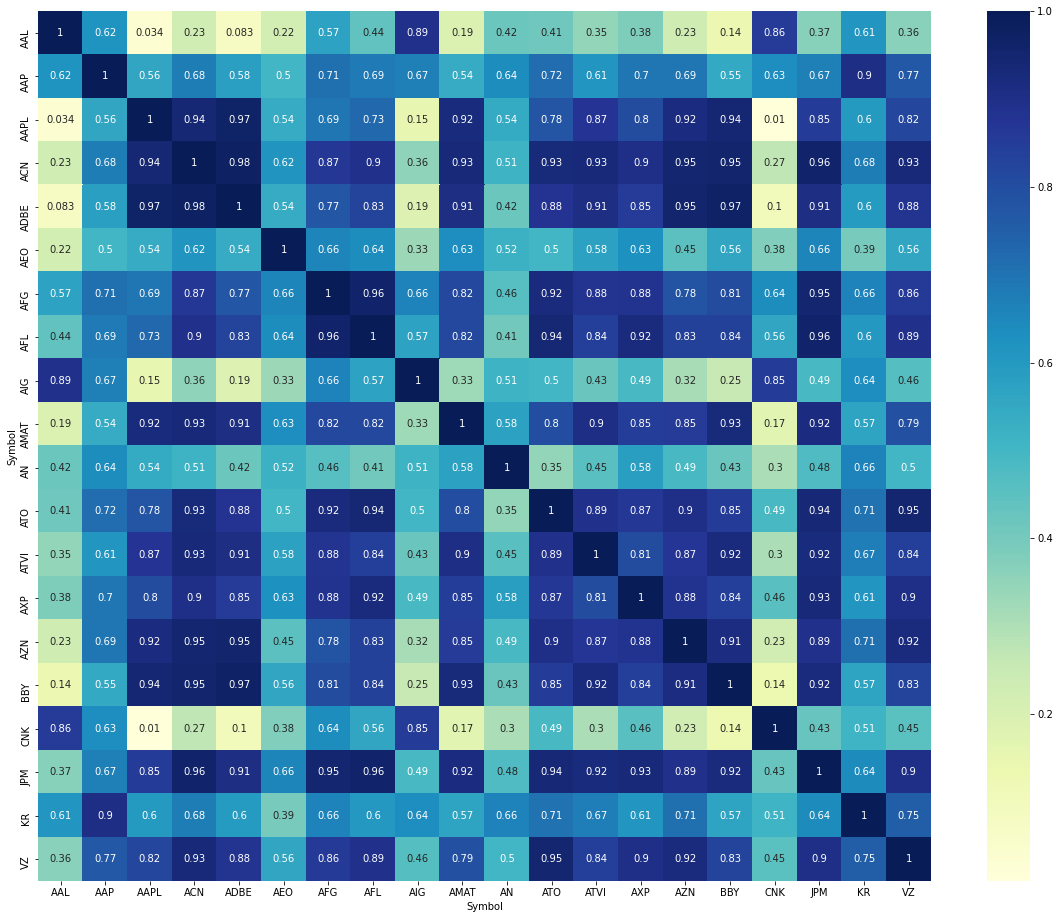

In [10]:
plt.figure(figsize=(20,16))
sns.heatmap(cormat, annot=True, cmap='YlGnBu');

We can see a bunch of high-looking correlations in this heatmap. But relatively high correlations between stocks are to be expected! What can we *actually* do to see if our stocks are *too* correlated? I am going to try examining the average correlation. If the average correlation for a stock is pretty high, then that stock is correlated with many of the others.

The diagonal of the correlation matrix is always 1, so we want to remove that, and then we want to sum up the rows or columns and divide by the number of stocks other than the one in question...that sounds complicated, but in matrix notation it looks like this:

$$\text{Average Correlation} \: = \: \frac{\sum_{j=1}^N \left( \rho_{ij} - I_{ij} \right)}{N-1}$$

Wherein $\mathbf{\rho}$ is the correlation matrix, $\mathbf{I}$ is the $N\times N$ identity matrix, and $N$ is the total number of stocks in the universe.

In [11]:
import numpy as np

In [12]:
avg_cor = ((cormat-np.identity(cormat.shape[0])).sum()/(cormat.shape[0]-1))
avg_cor

Symbol
AAL     0.390618
AAP     0.654162
AAPL    0.667291
ACN     0.763398
ADBE    0.701165
AEO     0.522086
AFG     0.766082
AFL     0.755623
AIG     0.479347
AMAT    0.708123
AN      0.487826
ATO     0.753418
ATVI    0.736892
AXP     0.752806
AZN     0.725751
BBY     0.703322
CNK     0.409948
JPM     0.778492
KR      0.636271
VZ      0.757531
dtype: float64

What cutoff indicates *too much* correlation? We really have no way of knowing. Our highest is 0.78, which is *kind of* high...and we have 7 stocks with average correlations higher than 0.75, or nearly 40% of our stock universe. It wouldn't be a bad idea to change those with less correlated stocks.

In [13]:
avg_cor[avg_cor >= 0.75]

Symbol
ACN    0.763398
AFG    0.766082
AFL    0.755623
ATO    0.753418
AXP    0.752806
JPM    0.778492
VZ     0.757531
dtype: float64

We need to replace those with stocks that are uncorrelated with them, probably from disparate industries. The stocks we want to replace are:

* ACN - Accenture, Consulting
    * This one is tough because consulting is not well-defined. What is different from consulting? We will try...Smith and Wesson (SWBI), the firearms manufacturer. That seems really different from consulting.
* AFG - American Financial Group, Finance
    * We will replace this one with Penn National Gaming (PENN), a casino gaming company.
* ATO - Atmos Energy, Energy
    * We will replace this one with ExxonMobil (XOM), which might have negative correlation with Atmos. We'll see.
* AXP - American Express, Consumer Finance
    * We will replace this one with Costco (COST)
* JPM - JP Morgan Chase, Finance
    * We will replace this one with J&J Snack Foods Corp (JJSF)
* VZ - Verizon, Telecom
    * We will replace this one with Starbucks (SBUX)
    
Let's replace them and check the correlations again.

In [14]:
data['Symbol'].unique()

array(['AAPL', 'AAL', 'AAP', 'AEO', 'ADBE', 'AFG', 'AFL', 'AIG', 'AMAT',
       'AN', 'ATO', 'ATVI', 'AXP', 'AZN', 'BBY', 'KR', 'JPM', 'CNK', 'VZ',
       'ACN'], dtype=object)

In [15]:
old_symbols = ['ACN', 'AFG', 'ATO', 'AXP', 'JPM', 'VZ']
new_symbols = ['SWBI', 'PENN', 'XOM', 'COST', 'JJSF', 'SBUX']

data = data.reset_index()
for i in range(len(old_symbols)):
    data = data.drop(data[data['Symbol'] == old_symbols[i]].index)
    temp = pd.read_csv('https://query1.finance.yahoo.com/v7/finance/download/'+new_symbols[i]+'?period1=1274054400&period2=1621209600&interval=1wk&events=history&includeAdjustedClose=true')
    temp['Symbol'] = new_symbols[i]
    data = data.append(temp[['Date', 'Symbol', 'Adj Close', 'Volume']], ignore_index=True)

In [16]:
data = data.set_index('Date')

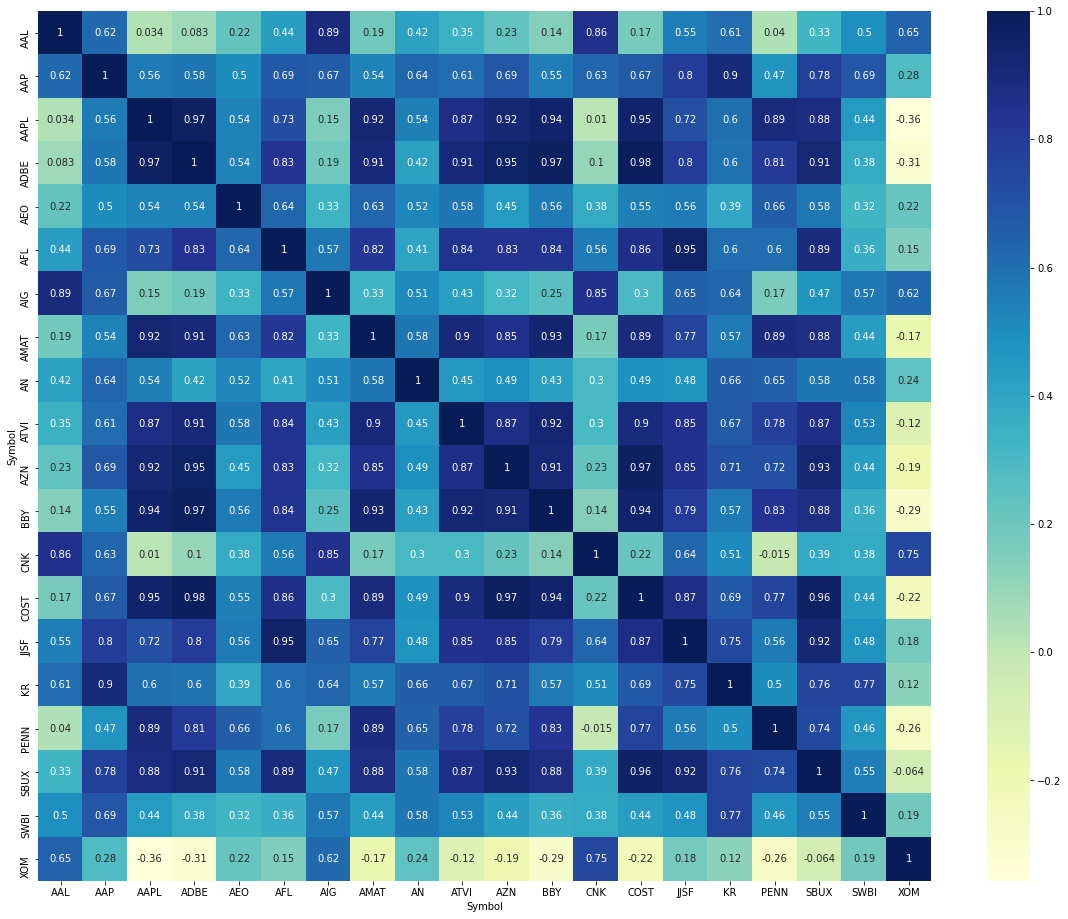

In [17]:
data_wide = data.pivot(columns = 'Symbol')
close_prices = data_wide['Adj Close']
cormat = close_prices.corr()
plt.figure(figsize=(20,16))
sns.heatmap(cormat, annot=True, cmap='YlGnBu');

In [18]:
avg_cor = ((cormat-np.identity(cormat.shape[0])).sum()/(cormat.shape[0]-1))
avg_cor

Symbol
AAL     0.385755
AAP     0.625175
AAPL    0.595647
ADBE    0.611405
AEO     0.483336
AFL     0.663635
AIG     0.469529
AMAT    0.633755
AN      0.494617
ATVI    0.658984
AZN     0.640372
BBY     0.614126
CNK     0.389619
COST    0.651459
JJSF    0.693215
KR      0.611995
PENN    0.540968
SBUX    0.695284
SWBI    0.467467
XOM     0.074219
dtype: float64

This is much better! Now, the highest average correlation is less than 0.7, so let's move on. We need to think of factors that we expect would have predictive power over the stock returns. I am more inclined to consider economic factors than fundamental factors, because I personally believe that economic factors have significant control over those fundamentals and their relationship to stock returns. For example, a retail company's Price/Sales ratio would be driven down by increased sales, and the increase in sales could be related to a change in unemployment or a shift in the price index.

## Gather Factors

I also only want to use economic factors that are measured on a weekly basis. This just makes it easier. We will be including previous stock prices in the models as well. The economic factors I will include are:

1. Crude Oil Prices - Measured by West Texas Intermediate (WTI) of Cushing, Oklahoma. Code WCOILWTICO on FRED.
2. Initial Unemployment Claims - ICSA on FRED.
3. The St. Louis Fed Financial Stress Index - A measure of stress in financial markets. Code STLFSI2 on FRED.
4. All Commercial Bank Deposits - DPSACBW027SBOG on FRED
5. Business Applications for the United States - Includes all applications for an Employer Identification Number (EIN) except in some special cases. Code BUSAPPWNSAUS on FRED.
6. US Regular Formulations All Gas Prices - A weighted average of gas prices across the country. Code GASREGW on FRED.
7. Insured Unemployment Rate - The proportion of unemployed who are covered by unemployment insurance. Code IURSA on FRED.
8. Effective Federal Funds Rate - Interest rate at which banks lend federal funds amongst themselves (overnight). Code FF on FRED.

That gives us 8 economic factors with easily measurable factor premiums. Let's download some factors and see if they are highly correlated. Hopefully not!

In [19]:
crude_oil = pd.read_csv('https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=WCOILWTICO&scale=left&cosd=1986-01-03&coed=2021-05-14&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Weekly%2C%20Ending%20Friday&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2021-05-19&revision_date=2021-05-19&nd=1986-01-03')
initial_claims = pd.read_csv('https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=ICSA&scale=left&cosd=1967-01-07&coed=2021-05-08&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Weekly%2C%20Ending%20Saturday&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2021-05-19&revision_date=2021-05-19&nd=1967-01-07')
stress_index = pd.read_csv('https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=STLFSI2&scale=left&cosd=1993-12-31&coed=2021-05-07&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Weekly%2C%20Ending%20Friday&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2021-05-19&revision_date=2021-05-19&nd=1993-12-31')
bank_deposits = pd.read_csv('https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=DPSACBW027SBOG&scale=left&cosd=1973-01-03&coed=2021-05-05&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Weekly%2C%20Ending%20Wednesday&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2021-05-19&revision_date=2021-05-19&nd=1973-01-03')
business_apps = pd.read_csv('https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=BUSAPPWNSAUS&scale=left&cosd=2006-01-07&coed=2021-05-08&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Weekly%2C%20Ending%20Saturday&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2021-05-19&revision_date=2021-05-19&nd=2006-01-07')
gas_prices = pd.read_csv('https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=GASREGW&scale=left&cosd=1990-08-20&coed=2021-05-17&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Weekly%2C%20Ending%20Monday&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2021-05-19&revision_date=2021-05-19&nd=1990-08-20')
insured_rate = pd.read_csv('https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=IURSA&scale=left&cosd=1971-01-02&coed=2021-05-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Weekly%2C%20Ending%20Saturday&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2021-05-19&revision_date=2021-05-19&nd=1971-01-02')
fed_funds_rate = pd.read_csv('https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=FF&scale=left&cosd=1954-07-07&coed=2021-05-12&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Weekly%2C%20Ending%20Wednesday&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2021-05-19&revision_date=2021-05-19&nd=1954-07-07')

In [20]:
crude_oil = crude_oil.set_index('DATE')
initial_claims = initial_claims.set_index('DATE')
stress_index = stress_index.set_index("DATE")
bank_deposits = bank_deposits.set_index("DATE")
business_apps = business_apps.set_index("DATE")
gas_prices = gas_prices.set_index("DATE")
insured_rate = insured_rate.set_index("DATE")
fed_funds_rate = fed_funds_rate.set_index("DATE")

The data is weekly, but the day on which is it reported is not uniform. We not only want to join this data together, but we also want to align the most recent economic factor reports with the nearest weekly stock prices.

In [21]:
crude_oil = crude_oil[(crude_oil.index >= "2010-05-10") & (crude_oil.index <= data.index.max())]
crude_oil.index = data.index.unique()
initial_claims = initial_claims[(initial_claims.index >= '2010-05-10') & (initial_claims.index <= data.index.max())]
initial_claims.index = data.index.unique()
stress_index = stress_index[(stress_index.index >= '2010-05-10') & (stress_index.index <= data.index.max())]
stress_index.index = data.index.unique()
bank_deposits = bank_deposits[(bank_deposits.index >= '2010-05-10') & (bank_deposits.index <= data.index.max())]
bank_deposits.index = data.index.unique()
business_apps = business_apps[(business_apps.index >= '2010-05-10') & (business_apps.index <= data.index.max())]
business_apps.index = data.index.unique()
gas_prices = gas_prices[(gas_prices.index >= '2010-05-10') & (gas_prices.index < data.index.max())]
gas_prices.index = data.index.unique()
insured_rate = insured_rate[(insured_rate.index >= '2010-05-08') & (insured_rate.index <= data.index.max())]
insured_rate.index = data.index.unique()
fed_funds_rate = fed_funds_rate[(fed_funds_rate.index >= '2010-05-07') & (fed_funds_rate.index <= data.index.max())]
fed_funds_rate.index = data.index.unique()

In [22]:
# now join them together
factors = crude_oil.join(initial_claims).join(stress_index).join(bank_deposits).join(business_apps).join(gas_prices).join(insured_rate).join(fed_funds_rate)
factors.head()

,WCOILWTICO,ICSA,STLFSI2,DPSACBW027SBOG,BUSAPPWNSAUS,GASREGW,IURSA,FF
Date,,,,,,,,
2010-05-17,74.98,474000,0.2328,7691.0986,51650,2.905,3.7,0.20
2010-05-24,69.14,463000,0.8460,7659.3660,51050,2.864,3.7,0.20
2010-05-31,70.62,458000,0.8709,7669.7873,50890,2.786,3.7,0.20
2010-06-07,72.91,459000,0.6619,7675.2687,50860,2.728,3.5,0.19
2010-06-14,73.44,467000,0.8280,7687.0307,40180,2.725,3.6,0.19


Now we've got 8 economic factors (which is a small number, but will work for this preliminary trial). But they are very difference sizes. The Fed Funds rate is less than 1, while Initial Claims in the hundreds of thousands! We will need a way to get these close to the same scale. And it needs to be a method that avoids look-ahead bias. Rolling z-score is a good choice, although it does result in some data loss. We just need to pick a rolling window that makes sense. How about 6 months, or 21 weeks? That sounds good let's do that.

In [23]:
factors.loc[factors['BUSAPPWNSAUS'] == '.', 'BUSAPPWNSAUS'] = np.nan
factors = factors.fillna(method='ffill')
factors['BUSAPPWNSAUS'] = factors['BUSAPPWNSAUS'].astype(int)
factors['GASREGW'] = factors['GASREGW'].astype(float)

In [24]:
rolling_mean = factors.rolling(21).mean().dropna()
rolling_sd = factors.rolling(21).std().dropna()

# Check the range
factors_zscore = (factors - rolling_mean).dropna() / rolling_sd
factors_zscore.max() - factors_zscore.min()

WCOILWTICO        6.240456
ICSA              7.443661
STLFSI2           6.504597
DPSACBW027SBOG    4.084893
BUSAPPWNSAUS      7.795668
GASREGW           6.788333
IURSA             8.728716
FF                8.454742
dtype: float64

The ranges are pretty consistent, so the scaling seems to be working. Creating the rolling z-scores means we only have 554 useable observations, from 2010-10-04 through 2021-05-10. 

Now, let's say that a stock's weekly return depends on:

* The stock's previous 4 weekly returns
* The stock's previous 4 weekly volumes
* The last 4 weekly measures of the economic factors

Mathematically, it would look something like this...

$$r_{i,t} = f\left( \vec{r}_{i, t-4:t-1}, \vec{v}_{i,t-4:t-1}, \vec{\beta}_{t-4:t-1} \right) + \epsilon_{i,t}$$

We will be using a neural network with Convolutional and Long-Short-Term-Memory layers to approximate the function in that model. $\epsilon_{i,t}$ is the random part that the function cannot fit. We hope it will be normally distributed, centered at zero, and with a small variance...but so long as the error is small our predictions should be useful.

Let's look at the range of the weekly percent returns for all of those stocks and see if we need to scale those.

In [25]:
pct_returns = data_wide['Adj Close'].pct_change().dropna()
pct_returns.max() - pct_returns.min()

Symbol
AAL     1.101673
AAP     0.617804
AAPL    0.322637
ADBE    0.321026
AEO     0.687489
AFL     0.553816
AIG     0.643319
AMAT    0.444270
AN      0.589260
ATVI    0.383093
AZN     0.306986
BBY     0.587793
CNK     0.881046
COST    0.234179
JJSF    0.319363
KR      0.423046
PENN    1.060006
SBUX    0.341820
SWBI    0.728987
XOM     0.368034
dtype: float64

The ranges seem reasonable. I don't want to scale these if we don't need to. We will modelling using unscaled pct-returns as the dependent variable and see if we can get the model accurate enough to be useful.

We are going to do this one at a time, so...AAL first.

Oh! And I forgot to scale the volume using the rolling z-score technique. So I am going to do that as needed.

## First CNN-LSTM model

#### Put all the variables together

In [26]:
dependent = pct_returns['AAL']
volume = data_wide['Volume']['AAL']
volume_mean = volume.rolling(21).mean().dropna()
volume_std = volume.rolling(21).std().dropna()
volume_zscore = (volume - volume_mean).dropna() / volume_std
volume_zscore.name = 'VOLUME'

In [27]:
independent = factors_zscore.join(volume_zscore).join(dependent, how='left')
dependent = dependent[independent.index]
independent

,WCOILWTICO,ICSA,STLFSI2,DPSACBW027SBOG,BUSAPPWNSAUS,GASREGW,IURSA,FF,VOLUME,AAL
Date,,,,,,,,,,
2010-10-04,1.113387,-1.307383,-1.032061,0.846629,0.567634,-0.881921,-0.912871,0.952562,-1.38869,-0.023681
2010-10-11,2.078973,-0.160475,-1.240118,1.401924,0.509081,-0.056414,-0.845154,0.195024,-0.799942,0.069460
2010-10-18,1.878125,-1.315517,-1.704277,1.516409,0.161290,2.556471,-0.791559,-0.556846,0.550592,0.114433
2010-10-25,1.445701,-1.967723,-1.218162,1.578066,-1.079883,2.551808,-0.765559,0.328161,0.17437,0.090657
2010-11-01,1.552798,-0.398195,-1.560937,1.726382,1.003408,1.824899,-2.309401,0.328161,-0.642606,-0.018660
...,...,...,...,...,...,...,...,...,...,...
2021-04-12,0.731366,-2.512162,-1.930014,1.788479,0.472080,1.477826,-1.321272,-1.118034,-0.798807,-0.064146
2021-04-19,1.014514,-2.267079,-1.401705,1.780807,0.938375,1.312433,-1.431682,-1.017630,-0.240611,-0.041761
2021-04-26,0.968721,-1.785686,-0.833974,1.548876,0.887894,1.217942,-1.298127,-0.941647,-0.727694,0.028896


#### Cut into Slices

We want to use the previous 4 observations to predict the next observation in the dependent variable (AAL percent return). 

We need a function that makes such slicing easy.

In [28]:
def slice_sequences(X_df, y_vector, past_obs=4, predict_obs=1):
    X = []
    y = []
    for i in range(past_obs, len(X_df)):
        past = np.array(X_df.iloc[i-past_obs:i])
        future = np.array(y_vector.iloc[i:i+predict_obs])
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [29]:
X, y = slice_sequences(independent, dependent)

That should do it. Below, we can see that it worked well. The first X array has a vector of all 10 observed measurements from week 1, then week 2, week 3, and week 4.

y is just a vector of single values, the returns for the following week.

In [30]:
X[0]

array([[1.1133866999210782, -1.307383060758639, -1.0320611256014571,
        0.8466290602296438, 0.5676339603989595, -0.8819214211765599,
        -0.9128709291752787, 0.95256241012336, -1.3886887388871791,
        -0.02368125295227841],
       [2.0789727546299734, -0.16047548396057426, -1.2401176422345184,
        1.4019243898432083, 0.5090807232504204, -0.05641393336892606,
        -0.8451542547285189, 0.19502405770136919, -0.7999415912561177,
        0.06945997767425127],
       [1.8781254006145638, -1.3155171488287691, -1.7042771979717917,
        1.5164086193106052, 0.16128988838949923, 2.556470682561546,
        -0.7915594835766253, -0.5568460463897009, 0.5505923059288447,
        0.11443296443778705],
       [1.4457013023929965, -1.9677234793114413, -1.2181618605646969,
        1.5780658585417762, -1.0798829820919038, 2.551807664681422,
        -0.7655590023509486, 0.328161117436453, 0.17436956021307398,
        0.09065662306986044]], dtype=object)

In [31]:
y[0]

array([-0.01865987])

Because we are using CNN layers, we need to split the weeks up into two biweekly subgroups...the input shape for the model will be:

`[number of groups, number of subgroups, number of weeks per subgroup, number of observations per week]`

or

`[1, 2, 2, 10]`

In [32]:
X.shape

(550, 4, 10)

In [33]:
X = X.reshape(X.shape[0], 1, 2, 2, 10)
X.shape

(550, 1, 2, 2, 10)

There we go. The y shape should be fine, I think. Let's split the data into training, validation, and test periods.

In [34]:
X_test = X[-52:]
y_test = y[-52:]
X_valid = X[-104:-52]
y_valid = y[-104:-52]
X_train = X[:-104]
y_train = y[:-104]

X_train = np.asarray(X_train).astype('float32')
X_valid = np.asarray(X_valid).astype('float32')
X_test = np.asarray(X_test).astype('float32')

Now, we have 446 training observations, 52 validation observations, and 52 testing observations. We will NOT have anything to do with the testing observations until we have completely built the trading strategy.

Let's actually construct the model now.

#### CNN-LSTM Architecture

In [35]:
import tensorflow as tf

In [36]:
y_train = y_train.reshape(y_train.shape[0],)
y_valid = y_valid.reshape(y_valid.shape[0],)
y_test = y_test.reshape(y_test.shape[0])

In [37]:
subgroups = 2
weeks_per_subgroup = 2
observations_per_week = 10

model = tf.keras.models.Sequential([
    tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=64,
                                                           kernel_size=1,
                                                           activation='relu'),
                                   input_shape = (None, subgroups, weeks_per_subgroup, observations_per_week)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=1)),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),
    tf.keras.layers.LSTM(50, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse')

In [41]:
history = model.fit(X_train, y_train, epochs=5000, verbose=False, validation_data=(X_valid, y_valid))
model.save('AAL_model1.h5')

In [42]:
model = tf.keras.models.load_model('AAL_model1.h5')

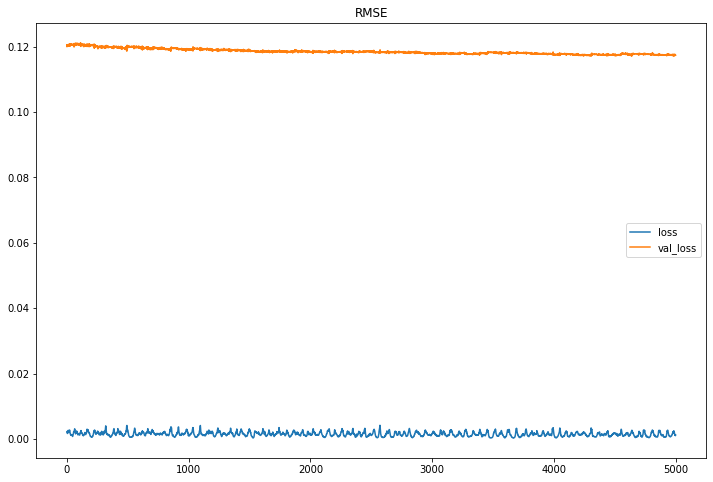

In [44]:
plt.figure(figsize=(12,8))
plt.plot(np.sqrt(history.history['loss']), label='loss')
plt.plot(np.sqrt(history.history['val_loss']), label='val_loss')
plt.title("RMSE")
plt.legend();

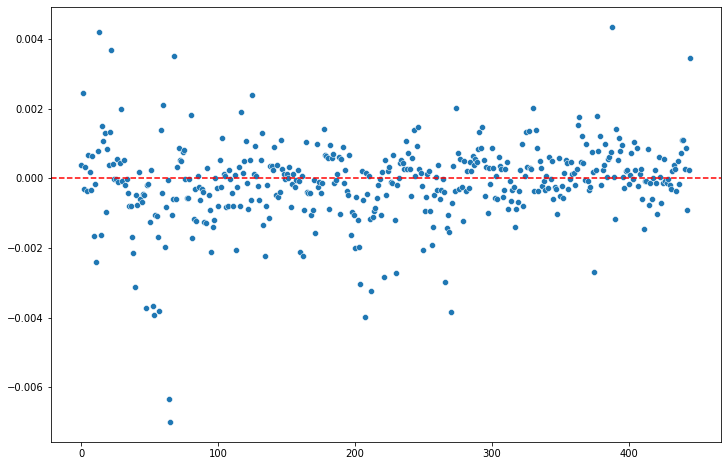

In [45]:
y_train_pred = model.predict(X_train)
resid = y_train - y_train_pred.reshape(446,)
plt.figure(figsize=(12,8))
sns.scatterplot(x=range(len(resid)), y=resid)
plt.axhline(y=0, color='red', linestyle='dashed');

In [46]:
np.std(resid)

0.0011502385037456494

Thought I would try a TON of epochs to see how that went. We can see that the models is overfitting the training data. This is a great sign. Overfitting in general is bad, but when the model overfits the training data, you can know it is finding useful patterns. The residuals also look nice; small and centered around zero.

Let's look at a few more plots.

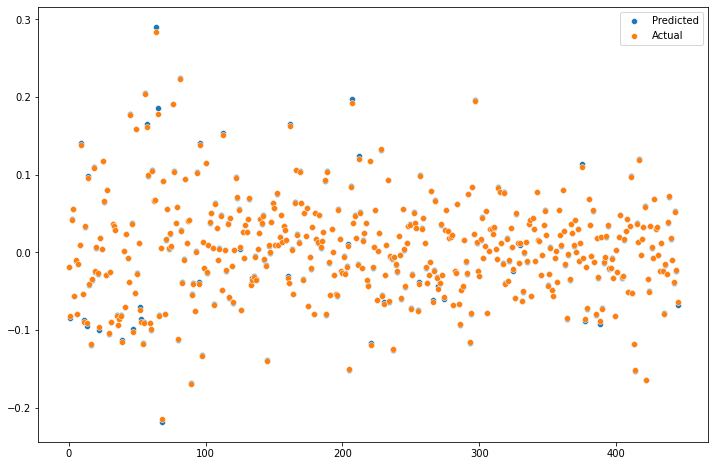

In [47]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=range(y_train_pred.shape[0]), y=y_train_pred.reshape((y_train_pred.shape[0],)), label='Predicted')
sns.scatterplot(x=range(y_train.shape[0]), y=y_train, label='Actual')
plt.legend();

I decided to use a scatterplot rather than lineplot to compare the predictions and actual values because the lineplot looked *too* good. We can see that the predictions are mostly dead on! Of course, this is the training data...let's check the validation data. But keep in mind, in the backtest, we will retrain the model on new information on each timestep.

In [48]:
y_valid_pred = model.predict(X_valid)
y_valid_pred = y_valid_pred.reshape((y_valid_pred.shape[0],))
valid_resid = y_valid - y_valid_pred
np.std(valid_resid)

0.11671665891701083

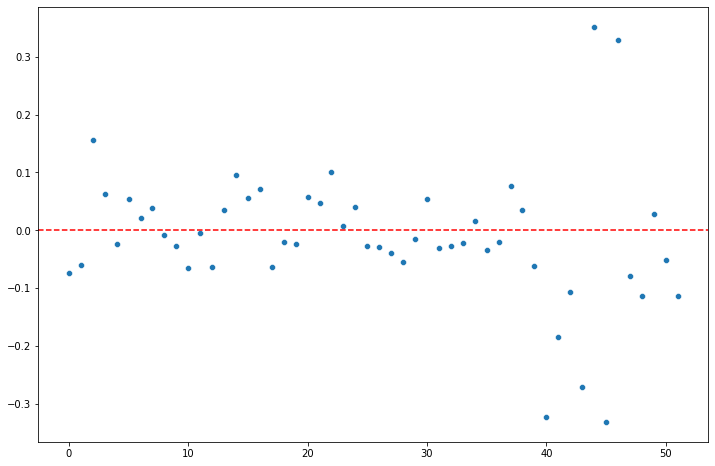

In [49]:
plt.figure(figsize=(12,8))
sns.scatterplot(x=range(len(valid_resid)), y=valid_resid)
plt.axhline(y=0, color='red', linestyle='dashed');

The residuals are still centered around zero, but they are spread much, much wider than on the training data. But remember, the model will be retrained on new information every week. Let's look at predictions compared to the real values.

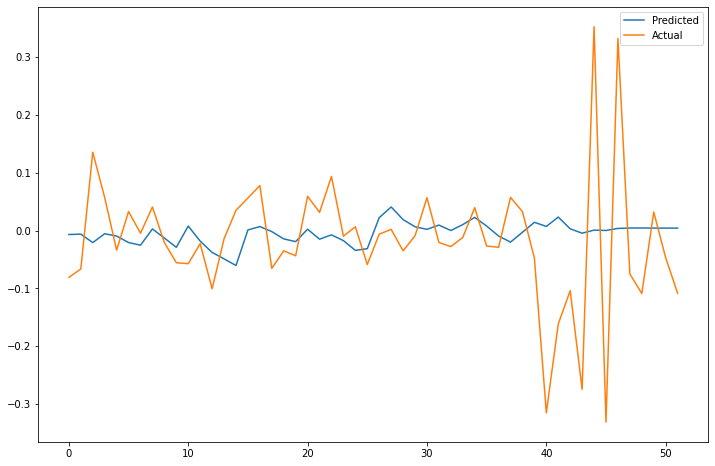

In [50]:
plt.figure(figsize=(12,8))
sns.lineplot(x=range(y_valid_pred.shape[0]), y=y_valid_pred, label='Predicted')
sns.lineplot(x=range(y_valid.shape[0]), y=y_valid, label='Actual')
plt.legend();

It becomes pretty obvious that the model does not perform all that well on the validation data. It underestimates the variance, especially toward the end. But again, remember that we will be retraining the model at each timestep.
Actually, let's set that up now...

In [51]:
past = X_train.copy()
outcomes = y_train.copy()
predictions = []
for t in range(len(X_valid)):
    #get new info
    new_info = X_valid[t].reshape(1,1,2,2,10)
    
    #make prediction based on new info
    predictions.append(model.predict(new_info))
    
    #add new_info to past
    past = np.append(past, new_info).reshape((past.shape[0]+1, 1, 2, 2, 10))
    #get new outcome and append to outcomes
    new_outcome = y_valid[t]
    outcomes = np.append(outcomes, y_valid[t])
    
    #train model on past data
    model.fit(past, outcomes, epochs=20)

Epoch 1/20
14/14 [==============================] - 1s 7ms/step - loss: 1.5292e-05
Epoch 2/20
14/14 [==============================] - 0s 7ms/step - loss: 8.7797e-06
Epoch 3/20
14/14 [==============================] - 0s 3ms/step - loss: 6.1500e-06
Epoch 4/20
14/14 [==============================] - 0s 8ms/step - loss: 6.4167e-06
Epoch 5/20
14/14 [==============================] - 0s 7ms/step - loss: 7.4265e-06
Epoch 6/20
14/14 [==============================] - 0s 3ms/step - loss: 7.9763e-06
Epoch 7/20
14/14 [==============================] - 0s 7ms/step - loss: 5.2976e-06
Epoch 8/20
14/14 [==============================] - 0s 7ms/step - loss: 4.2450e-06
Epoch 9/20
14/14 [==============================] - 0s 7ms/step - loss: 2.9318e-06
Epoch 10/20
14/14 [==============================] - 0s 7ms/step - loss: 1.8705e-06
Epoch 11/20
14/14 [==============================] - 0s 7ms/step - loss: 1.6637e-06
Epoch 12/20
14/14 [==============================] - 0s 7ms/step - loss: 1.3353e-06
E

15/15 [==============================] - 0s 7ms/step - loss: 2.6870e-07
Epoch 19/20
15/15 [==============================] - 0s 9ms/step - loss: 1.4236e-07
Epoch 20/20
15/15 [==============================] - 0s 5ms/step - loss: 8.5878e-08
Epoch 1/20
15/15 [==============================] - 0s 6ms/step - loss: 4.0085e-06
Epoch 2/20
15/15 [==============================] - 0s 7ms/step - loss: 3.1008e-06
Epoch 3/20
15/15 [==============================] - 0s 7ms/step - loss: 2.0891e-06
Epoch 4/20
15/15 [==============================] - 0s 7ms/step - loss: 1.9539e-06
Epoch 5/20
15/15 [==============================] - 0s 7ms/step - loss: 1.2444e-06
Epoch 6/20
15/15 [==============================] - 0s 7ms/step - loss: 7.6544e-07
Epoch 7/20
15/15 [==============================] - 0s 6ms/step - loss: 5.4205e-07
Epoch 8/20
15/15 [==============================] - 0s 7ms/step - loss: 2.9587e-07
Epoch 9/20
15/15 [==============================] - 0s 7ms/step - loss: 1.7766e-07
Epoch 10/20
1

15/15 [==============================] - 0s 7ms/step - loss: 1.4734e-06
Epoch 16/20
15/15 [==============================] - 0s 2ms/step - loss: 2.4760e-06
Epoch 17/20
15/15 [==============================] - 0s 7ms/step - loss: 3.6196e-06
Epoch 18/20
15/15 [==============================] - 0s 7ms/step - loss: 3.3763e-06
Epoch 19/20
15/15 [==============================] - 0s 7ms/step - loss: 3.2229e-06
Epoch 20/20
15/15 [==============================] - 0s 6ms/step - loss: 5.3625e-06
Epoch 1/20
15/15 [==============================] - 0s 7ms/step - loss: 1.4149e-05
Epoch 2/20
15/15 [==============================] - 0s 7ms/step - loss: 1.6385e-05
Epoch 3/20
15/15 [==============================] - 0s 6ms/step - loss: 1.9063e-05
Epoch 4/20
15/15 [==============================] - 0s 7ms/step - loss: 9.2507e-06
Epoch 5/20
15/15 [==============================] - 0s 7ms/step - loss: 5.1175e-06
Epoch 6/20
15/15 [==============================] - 0s 7ms/step - loss: 3.6124e-06
Epoch 7/20

15/15 [==============================] - 0s 8ms/step - loss: 2.2904e-06
Epoch 13/20
15/15 [==============================] - 0s 7ms/step - loss: 1.7293e-06
Epoch 14/20
15/15 [==============================] - 0s 6ms/step - loss: 1.6177e-06
Epoch 15/20
15/15 [==============================] - 0s 7ms/step - loss: 3.0603e-06
Epoch 16/20
15/15 [==============================] - 0s 7ms/step - loss: 1.9531e-06
Epoch 17/20
15/15 [==============================] - 0s 7ms/step - loss: 1.3705e-06
Epoch 18/20
15/15 [==============================] - 0s 7ms/step - loss: 1.4680e-06
Epoch 19/20
15/15 [==============================] - 0s 7ms/step - loss: 2.6831e-06
Epoch 20/20
15/15 [==============================] - 0s 7ms/step - loss: 1.5890e-06
Epoch 1/20
15/15 [==============================] - 0s 2ms/step - loss: 1.4637e-06
Epoch 2/20
15/15 [==============================] - 0s 7ms/step - loss: 1.1543e-06
Epoch 3/20
15/15 [==============================] - 0s 3ms/step - loss: 9.4247e-07
Epoch 4

15/15 [==============================] - 0s 7ms/step - loss: 8.7258e-07
Epoch 11/20
15/15 [==============================] - 0s 7ms/step - loss: 6.7860e-07
Epoch 12/20
15/15 [==============================] - 0s 6ms/step - loss: 7.4194e-07
Epoch 13/20
15/15 [==============================] - 0s 8ms/step - loss: 7.4418e-07
Epoch 14/20
15/15 [==============================] - 0s 6ms/step - loss: 7.5527e-07
Epoch 15/20
15/15 [==============================] - 0s 6ms/step - loss: 5.8251e-07
Epoch 16/20
15/15 [==============================] - 0s 7ms/step - loss: 5.4518e-07
Epoch 17/20
15/15 [==============================] - 0s 7ms/step - loss: 4.1606e-07
Epoch 18/20
15/15 [==============================] - 0s 7ms/step - loss: 4.0662e-07
Epoch 19/20
15/15 [==============================] - 0s 7ms/step - loss: 7.8350e-07
Epoch 20/20
15/15 [==============================] - 0s 7ms/step - loss: 5.0976e-07
Epoch 1/20
15/15 [==============================] - 0s 7ms/step - loss: 8.4846e-06
Epoch

15/15 [==============================] - 0s 2ms/step - loss: 1.0669e-07
Epoch 8/20
15/15 [==============================] - 0s 7ms/step - loss: 8.0679e-08
Epoch 9/20
15/15 [==============================] - 0s 7ms/step - loss: 6.7840e-08
Epoch 10/20
15/15 [==============================] - 0s 12ms/step - loss: 4.5436e-08
Epoch 11/20
15/15 [==============================] - 0s 7ms/step - loss: 3.6869e-08
Epoch 12/20
15/15 [==============================] - 0s 7ms/step - loss: 3.9571e-08
Epoch 13/20
15/15 [==============================] - 0s 8ms/step - loss: 4.4191e-08
Epoch 14/20
15/15 [==============================] - 0s 7ms/step - loss: 4.8624e-08
Epoch 15/20
15/15 [==============================] - 0s 7ms/step - loss: 5.9711e-08
Epoch 16/20
15/15 [==============================] - 0s 7ms/step - loss: 7.0247e-08
Epoch 17/20
15/15 [==============================] - 0s 7ms/step - loss: 8.2712e-08
Epoch 18/20
15/15 [==============================] - 0s 7ms/step - loss: 6.9700e-08
Epoch

15/15 [==============================] - 0s 9ms/step - loss: 5.4679e-06
Epoch 6/20
15/15 [==============================] - 0s 3ms/step - loss: 4.5731e-06
Epoch 7/20
15/15 [==============================] - 0s 8ms/step - loss: 4.4094e-06
Epoch 8/20
15/15 [==============================] - 0s 7ms/step - loss: 3.9426e-06
Epoch 9/20
15/15 [==============================] - 0s 7ms/step - loss: 4.7721e-06
Epoch 10/20
15/15 [==============================] - 0s 7ms/step - loss: 3.9111e-06
Epoch 11/20
15/15 [==============================] - 0s 7ms/step - loss: 3.5109e-06
Epoch 12/20
15/15 [==============================] - 0s 8ms/step - loss: 2.2381e-06
Epoch 13/20
15/15 [==============================] - 0s 8ms/step - loss: 1.5700e-06
Epoch 14/20
15/15 [==============================] - 0s 7ms/step - loss: 1.1701e-06
Epoch 15/20
15/15 [==============================] - 0s 8ms/step - loss: 9.0372e-07
Epoch 16/20
15/15 [==============================] - 0s 7ms/step - loss: 7.5410e-07
Epoch 17

16/16 [==============================] - 0s 7ms/step - loss: 2.6172e-06
Epoch 4/20
16/16 [==============================] - 0s 6ms/step - loss: 2.0074e-06
Epoch 5/20
16/16 [==============================] - 0s 7ms/step - loss: 1.9082e-05
Epoch 6/20
16/16 [==============================] - 0s 3ms/step - loss: 2.4598e-05
Epoch 7/20
16/16 [==============================] - 0s 7ms/step - loss: 2.9153e-05
Epoch 8/20
16/16 [==============================] - 0s 7ms/step - loss: 2.4619e-05
Epoch 9/20
16/16 [==============================] - 0s 6ms/step - loss: 2.6843e-05
Epoch 10/20
16/16 [==============================] - 0s 7ms/step - loss: 2.8224e-05
Epoch 11/20
16/16 [==============================] - 0s 6ms/step - loss: 2.6025e-05
Epoch 12/20
16/16 [==============================] - 0s 7ms/step - loss: 1.6654e-05
Epoch 13/20
16/16 [==============================] - 0s 7ms/step - loss: 1.0533e-05
Epoch 14/20
16/16 [==============================] - 0s 7ms/step - loss: 7.6551e-06
Epoch 15/2

16/16 [==============================] - 0s 2ms/step - loss: 1.4887e-05
Epoch 2/20
16/16 [==============================] - 0s 7ms/step - loss: 1.2229e-05
Epoch 3/20
16/16 [==============================] - 0s 2ms/step - loss: 9.1972e-06
Epoch 4/20
16/16 [==============================] - 0s 7ms/step - loss: 8.0588e-06
Epoch 5/20
16/16 [==============================] - 0s 9ms/step - loss: 5.8129e-06
Epoch 6/20
16/16 [==============================] - 0s 7ms/step - loss: 4.3920e-06
Epoch 7/20
16/16 [==============================] - 0s 7ms/step - loss: 3.8718e-06
Epoch 8/20
16/16 [==============================] - 0s 7ms/step - loss: 4.4913e-06
Epoch 9/20
16/16 [==============================] - 0s 6ms/step - loss: 3.1375e-06
Epoch 10/20
16/16 [==============================] - 0s 7ms/step - loss: 2.7143e-06
Epoch 11/20
16/16 [==============================] - 0s 11ms/step - loss: 2.5569e-06
Epoch 12/20
16/16 [==============================] - 0s 7ms/step - loss: 3.1284e-06
Epoch 13/20

16/16 [==============================] - 0s 10ms/step - loss: 1.9585e-06
Epoch 20/20
16/16 [==============================] - 0s 2ms/step - loss: 1.2813e-06
Epoch 1/20
16/16 [==============================] - 0s 8ms/step - loss: 2.5393e-04
Epoch 2/20
16/16 [==============================] - 0s 6ms/step - loss: 2.4537e-04
Epoch 3/20
16/16 [==============================] - 0s 7ms/step - loss: 1.2580e-04
Epoch 4/20
16/16 [==============================] - 0s 6ms/step - loss: 1.2281e-04
Epoch 5/20
16/16 [==============================] - 0s 6ms/step - loss: 7.5806e-04
Epoch 6/20
16/16 [==============================] - 0s 7ms/step - loss: 1.9327e-04
Epoch 7/20
16/16 [==============================] - 0s 7ms/step - loss: 1.2956e-04
Epoch 8/20
16/16 [==============================] - 0s 6ms/step - loss: 9.3283e-05
Epoch 9/20
16/16 [==============================] - 0s 6ms/step - loss: 3.5063e-05
Epoch 10/20
16/16 [==============================] - 0s 6ms/step - loss: 1.1781e-05
Epoch 11/20


16/16 [==============================] - 0s 7ms/step - loss: 3.0121e-05
Epoch 18/20
16/16 [==============================] - 0s 7ms/step - loss: 2.7728e-05
Epoch 19/20
16/16 [==============================] - 0s 7ms/step - loss: 2.5486e-05
Epoch 20/20
16/16 [==============================] - 0s 7ms/step - loss: 2.4968e-05
Epoch 1/20
16/16 [==============================] - 0s 2ms/step - loss: 3.1167e-05
Epoch 2/20
16/16 [==============================] - 0s 2ms/step - loss: 2.9637e-05
Epoch 3/20
16/16 [==============================] - 0s 7ms/step - loss: 3.2192e-05
Epoch 4/20
16/16 [==============================] - 0s 7ms/step - loss: 3.4930e-05
Epoch 5/20
16/16 [==============================] - 0s 7ms/step - loss: 3.6700e-05
Epoch 6/20
16/16 [==============================] - 0s 7ms/step - loss: 3.5743e-05
Epoch 7/20
16/16 [==============================] - 0s 7ms/step - loss: 3.2177e-05
Epoch 8/20
16/16 [==============================] - 0s 7ms/step - loss: 3.1072e-05
Epoch 9/20
1

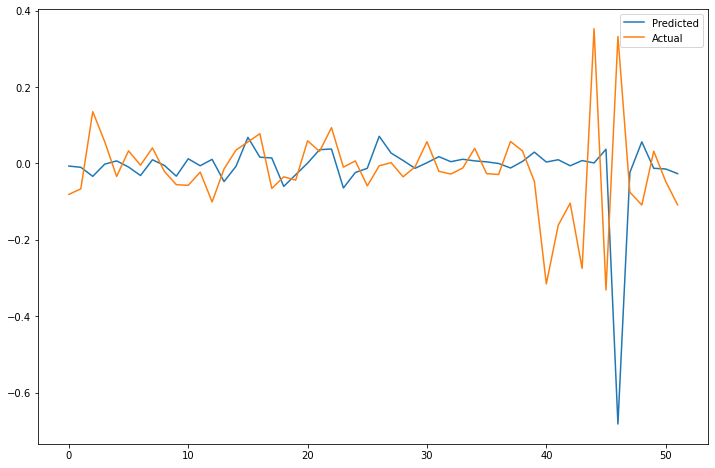

In [52]:
predictions = np.array(predictions).reshape((len(predictions),))
plt.figure(figsize=(12,8))
sns.lineplot(x = range(len(predictions)), y=predictions, label='Predicted')
sns.lineplot(x = range(len(y_valid)), y=y_valid, label='Actual')
plt.legend();

The predictions are not especially accurate, but the secret is...it doesn't really need to be. For years, active managers have been successful using very simple linear models of returns based on economic factors. Quantitative portfolio management uses the insights gained from imperfect models to control risk.

Now that we've figured out how we want our models to work, we need to create one for each stock in our universe.

In [ ]:
universe = data['Symbol'].unique()
pred_df = pd.DataFrame(columns = universe)
for stock in universe:
    dependent = pct_returns[stock]
    volume = data_wide['Volume'][stock]
    volume_mean = volume.rolling(21).mean().dropna()
    volume_std = volume.rolling(21).std().dropna()
    volume_zscore = (volume - volume_mean).dropna() / volume_std
    volume_zscore.name = 'VOLUME'
    
    independent = factors_zscore.join(volume_zscore).join(dependent, how='left')
    dependent = dependent[independent.index]
    
    X, y = slice_sequences(independent, dependent)
    
    X = X.reshape((X.shape[0], 1, 2, 2, 10))
    y = y.reshape((y.shape[0],))
    
    X_test = X[-52:]
    y_test = y[-52:]
    X_valid = X[-104:-52]
    y_valid = y[-104:-52]
    X_train = X[:-104]
    y_train = y[:-104]

    X_train = np.asarray(X_train).astype('float32')
    X_valid = np.asarray(X_valid).astype('float32')
    X_test = np.asarray(X_test).astype('float32')
    
    subgroups = 2
    weeks_per_subgroup = 2
    observations_per_week = 10

    model = tf.keras.models.Sequential([
        tf.keras.layers.TimeDistributed(tf.keras.layers.Conv2D(filters=64,
                                                               kernel_size=1,
                                                               activation='relu'),
                                       input_shape = (None, subgroups, weeks_per_subgroup, observations_per_week)),
        tf.keras.layers.TimeDistributed(tf.keras.layers.MaxPooling2D(pool_size=1)),
        tf.keras.layers.TimeDistributed(tf.keras.layers.Flatten()),
        tf.keras.layers.LSTM(50, activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')
    
    history = model.fit(X_train, y_train, epochs=20, verbose=False, validation_data=(X_valid, y_valid))
    model.save(stock+'_model.h5')
    
    # now we want to walk through the validation window
    past = X_train.copy()
    outcomes = y_train.copy()
    predictions = []
    for t in range(len(X_valid)):
        #get new info
        new_info = X_valid[t].reshape(1,1,2,2,10)
        #make prediction based on new info
        predictions.append(model.predict(new_info))
    
        #add new_info to past
        past = np.append(past, new_info).reshape((past.shape[0]+1, 1, 2, 2, 10))
        #get new outcome and append to outcomes
        new_outcome = y_valid[t]
        outcomes = np.append(outcomes, y_valid[t])
    
        #train model on past data
        model.fit(past, outcomes, epochs=20, verbose=False)
        model.save(stock+'_model.h5')
        
    #save predictions 
    pred_df[stock] = predictions

# Start Here to Get Predictions

In [ ]:
import pandas as pd
import numpy as np


In [ ]:
pred_df = pd.read_csv('prediction_csv.csv')
pred_df.drop('Unnamed: 0', axis=1, inplace=True)
for stock in pred_df.columns:
    pred_df[stock] = [float(i[2:len(i)-2]) for i in pred_df[stock]]

### Use Predictions for Portfolio Management

The mathematical formula to find the weights for the portfolio with the highest Sharpe ratio is:

$$\vec{w} \: = \: \frac{\Sigma^{-1}\vec{\mu}}{1^{T}\Sigma^{-1}\vec{\mu}}$$

What we are going to do at every timestep, every week, is:

1. Use the predicted returns as $\vec{\mu}$
2. Append the predictions to the previous 20 days' returns
3. Calculate the covariance matrix, $\Sigma$, including the prediction
4. Use the formula to find the weights for the max Sharpe portfolio

### Backtesting

Also at each timestep...

5. Buy $w_i$ shares of each stock at the most recent price (in practice, we would scale these weights by some constant, but percent returns should be unaffected by scalar values)
6. Get the next week's info
7. Sell all shares of each stock the following week
8. Repeat

This is of course unrealistic...we couldn't really sell the shares at the new price, calculate the new weights, and then buy the next week's shares without the price changing. It would be possible to correct this, say by selling the shares at the open price and buying at the close price later in the day. But we can get a decent idea of strategy performance using the method above. Let's try it.

In [ ]:
import scipy.linalg as la

test_returns = pct_returns.iloc[-52:,:]
valid_returns = pct_returns.iloc[-104:-52,:]
train_returns = pct_returns.iloc[:-104,:]
pred_df.index = valid_returns.index

# at each timestep, use predicted returns for expected returns, find covariance,
# and make highest sharpe portfolio
past_returns = train_returns.iloc[-20:,:]
prices = data_wide['Adj Close'].loc[train_returns.index[-1]:valid_returns.index[-1],:]
stocks = prices.columns
port_val = [1]
port_ret = []
for t in range(len(pred_df)):
    # get mu
    vec_mu = pred_df.iloc[t,:]
    
    # get Sigma
    cov_returns = past_returns.append(vec_mu)
    Sigma = cov_returns.cov()
    
    # vector of ones
    ones = np.matrix([1]*len(vec_mu))
    
    # calculate weights
    Sigma_inv = la.inv(Sigma.values)
    vec_mu = vec_mu.values
    top = Sigma_inv @ vec_mu
    bottom = ones @ Sigma_inv @ vec_mu
    weights = top / bottom
    
    # buy shares at price t, sell at price t+1
    shares = (0.2*port_val[t]*np.array(weights).reshape((20,)))/prices.iloc[t,:]
    start_value = shares * prices.iloc[t,:]
    end_value = shares * prices.iloc[t+1,:]
    
    port_val.append(0.8*port_val[t] + end_value.sum())
    port_ret.append( (end_value.sum() - start_value.sum())/start_value.sum() )

In [ ]:
port_val = pd.DataFrame(port_val, columns=['Value'])
port_val.index = valid_returns.index.insert(0,'2019-05-13')
one_share_benchmark = data_wide['Adj Close'][port_val.index[0]:port_val.index[-1]].sum(axis=1)
one_share_benchmark = one_share_benchmark/one_share_benchmark[0]
equal_shares = (1/20) / data_wide['Adj Close'][port_val.index[0]:port_val.index[-1]].iloc[0,:]
equal_capital_benchmark = equal_shares * data_wide['Adj Close'][port_val.index[0]:port_val.index[-1]]
equal_capital_benchmark = equal_capital_benchmark.sum(axis=1)

In [ ]:
port_val.plot(figsize=(12,8), label='Strategy Portfolio')
one_share_benchmark.plot(label='One Share Benchmark')
equal_capital_benchmark.plot(label='Equal Capital Benchmark')
plt.legend();

In [ ]:
port_ret = port_val.pct_change().dropna()
one_share_ret = one_share_benchmark.pct_change().dropna()
equal_capital_ret = equal_capital_benchmark.pct_change().dropna()
port_ret.plot(label='Strategy Returns', figsize=(12,8))
one_share_ret.plot(label='One Share Benchmark Returns')
equal_capital_ret.plot(label='Equal Capital Benchmark returns')
plt.legend();